# SNR finder ANN model training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from ler.utils import add_dict_values, append_json, get_param_from_json, load_json, save_json
import tensorflow as tf

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

from gwsnr import antenna_response_array, cubic_spline_interpolator2d

In [2]:
# # Uncomment to generate new data to test the model

# # generating astrophysical data for testing using `ler` package
# from ler.rates import LeR
# from ler.utils import get_param_from_json

# ler = LeR(
#     npool=8,
#     z_max=10,  # becareful with this value
#     spin_zero=False,
#     spin_precession=True,
#     verbose=False,
#     mtot_max=500,
#     minimum_frequency=10,
#     waveform_approximant='IMRPhenomXPHM',
#     snr_type='inner_product',
#     ifos=['ET', 'CE'],
# )

# size_ = 50000
# ler.batch_size = 50000
# ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing_ETCE.json', resume=True);

In [4]:
# let's generate IMRPhenomXPHM (spinless) interpolartor for the partial_half (refer to gwsnr documentation)
# One of the training input is partial_snr
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='interpolation',
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomXPHM',
    ifos=['ET', 'CE'],
)

Interpolator will be generated for ET1 detector at ./interpolator_pickle/ET1/partialSNR_dict_1.pickle
Interpolator will be generated for ET2 detector at ./interpolator_pickle/ET2/partialSNR_dict_1.pickle
Interpolator will be generated for ET3 detector at ./interpolator_pickle/ET3/partialSNR_dict_1.pickle
Interpolator will be generated for CE detector at ./interpolator_pickle/CE/partialSNR_dict_1.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['ET1', 'ET2', 'ET3', 'CE'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [05:58<00:00,  7.17s/it]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  10
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10): 369.97199706893525
detectors:  ['ET1', 'ET2', 'ET3', 'CE']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='No

### Input-Output generator function

In [5]:
def input_data(idx, params):
    """
        Function to generate input and output data for the neural network
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # spinless snr
    snr = snr_half_ * amp0

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XET1 = np.vstack([snr[0], amp0[0], eta, chi_eff, theta_jn]).T
    XET2 = np.vstack([snr[1], amp0[1], eta, chi_eff, theta_jn]).T
    XET3 = np.vstack([snr[2], amp0[2], eta, chi_eff, theta_jn]).T
    XCE = np.vstack([snr[3], amp0[3], eta, chi_eff, theta_jn]).T

    return XET1, XET2, XET3, XCE

def input_output(idx, params, det='ET1'):

    XET1, XET2, XET3, XCE = input_data(idx, params)

    if det == 'ET1':
        X = XET1
        y = np.array(params['ET1'])[idx]
    elif det == 'ET2':
        X = XET2
        y = np.array(params['ET2'])[idx]
    elif det == 'ET3':
        X = XET3
        y = np.array(params['ET3'])[idx]
    # elif det == 'CE':
    #     X = XCE
    #     y = np.array(params['CE'])[idx]
    elif det == 'NET':
        yET1 = np.array(params['ET1'])[idx]
        yET2 = np.array(params['ET2'])[idx]
        yET3 = np.array(params['ET3'])[idx]
        yET = np.sqrt(yET1**2 + yET2**2 + yET3**2)
        # yCE = np.array(params['CE'])[idx]
        # yNET = np.sqrt(yET**2 + yCE**2)
        yNET = yET
        
        # return(XET1, yET1, XET2, yET2, XET3, yET3, XCE, yCE, yNET)
        return(XET1, yET1, XET2, yET2, XET3, yET3, yNET)

    return X, y

## For ET detector

### Get all necessary data

In [6]:
# these are pre-generated datas
# join all dictionaries into one
unlensed_params1 = get_param_from_json("ler_data/unlensed_param_ET.json")

# len_ = int(len(unlensed_params1['ET1'])/2)
# print(len_)
# for key, value in unlensed_params1.items():
#     unlensed_params1[key] = value[:len_]

unlensed_params2 = get_param_from_json("ler_data/joint_new_optsnr_ET1.json")

unlensed_params = add_dict_values(unlensed_params1, unlensed_params2)
del unlensed_params1, unlensed_params2

# snr = unlensed_params['ET1']
# idx = snr>0
# for key, value in unlensed_params.items():
#     unlensed_params[key] = value[idx]

# unlensed_params = get_param_from_json("ler_data/unlensed_param_ET.json")

print(f"size before SNR cut: {len(unlensed_params['ET1'])}")
# set SNR cut
idx_constrain = unlensed_params['ET1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['ET1'])}")

size before SNR cut: 697365
size after SNR cut: 696708


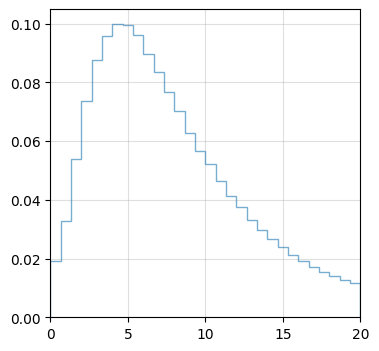

In [7]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['ET1'])
test = test[test<20]
plt.figure(figsize=(4,4))
plt.hist(test, bins=30, alpha=0.6, histtype='step', density=True)
plt.xlim(0,20)
plt.grid(alpha=0.4)
plt.show()

In [8]:
len_ = len(unlensed_params['ET1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XET1,yET1 = input_output(idx, unlensed_params, det='ET1')
np.shape(XET1)

(696708, 5)

* It is expected to have larger error in the sparse region of the input data, e.g. $\eta<0.2$

## Scaling the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(XET1, yET1, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerET1_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
# sc = scalerET1
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

### Generate ANN model

In [10]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 340us/step - accuracy: 8.1022e-05 - loss: 26.7634
Epoch 2/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 333us/step - accuracy: 4.3866e-06 - loss: 3.8817
Epoch 3/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 331us/step - accuracy: 2.5260e-05 - loss: 3.5139
Epoch 4/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 368us/step - accuracy: 2.7446e-05 - loss: 3.7995
Epoch 5/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step - accuracy: 5.7728e-05 - loss: 3.5808
Epoch 6/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 336us/step - accuracy: 1.2959e-04 - loss: 3.3529
Epoch 7/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 335us/step - accuracy: 2.3603e-04 - loss: 3.4217
Epoch 8/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 6s 327us/step - accuracy: 2.0444e-04 - loss: 3.1391
Epoch 9/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 7s 331us/step - accuracy: 2.2257e-04 - loss: 2.9304
Epoch 10/100
19595/19595 ━━━━━━━━━━━━━━━━━━━━ 6s 330us/step - accuracy: 4.9342e-04 - loss: 2.9196
Epoch 11/100
19595/19595 ━━━

In [12]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelET1_final.h5')
modelET1 = ann

In [13]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelET1 = load_model('ann_modelET1_final.h5')

### Test the Model on the test data

In [14]:
# left: predicted snr, right: actual snr
y_pred = modelET1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

2178/2178 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step
[[26.2891655  27.63367505]
 [11.49224854 11.36603721]
 [ 3.33380771  3.10222831]
 [ 5.38878918  5.09082781]
 [ 5.99786711  6.07512927]
 [ 4.02997208  3.78017034]
 [34.22657013 31.1040625 ]
 [ 5.38475084  5.52190493]
 [ 6.1685462   5.85286104]
 [ 5.79096413  5.85617613]
 [13.05470657 13.88994907]
 [15.52290726 15.03601211]
 [ 8.93467712  9.08254655]
 [18.09013557 15.92601414]
 [20.77788734 20.05668437]]


In [12]:
# left: predicted snr, right: actual snr
y_pred = modelET1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

2178/2178 ━━━━━━━━━━━━━━━━━━━━ 1s 230us/step
[[ 6.6826849   7.35809249]
 [ 5.56951427  5.42523128]
 [10.53016663 10.1989236 ]
 [26.41267586 27.44021167]
 [23.62282181 21.84402224]
 [ 5.35305595  5.65090402]
 [ 2.21993208  2.01032584]
 [ 2.9688313   2.74796444]
 [ 2.45241213  2.60097399]
 [ 6.19739437  6.09195775]
 [20.34118652 20.97324572]
 [29.94248199 32.60894487]
 [ 3.93978882  4.09372782]
 [ 9.95970917 10.0410052 ]
 [ 4.86493731  4.84587965]]


In [15]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.00%


In [13]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.03%


In [13]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.12%


In [13]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.08%


In [16]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37366  1194]
 [  893 30218]]
Accuracy: 97.004%


In [14]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37542  1124]
 [  989 30016]]
Accuracy: 96.967%


In [14]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37538  1171]
 [ 1005 29957]]
Accuracy: 96.877%


In [15]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37621   980]
 [ 1165 29905]]
Accuracy: 96.921%


### Test with astrophysical parameters

In [17]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['ET1'])), unlensed_params, det='ET1')
scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
X_ = scalerET1.transform(X_)

modelET1 = load_model('ann_modelET1_final.h5')
y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
[[26878   992]
 [  610 21520]]
Accuracy: 96.796%


In [16]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['ET1'])), unlensed_params, det='ET1')
scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
X_ = scalerET1.transform(X_)

modelET1 = load_model('ann_modelET1_final.h5')
y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
[[27110   760]
 [  837 21293]]
Accuracy: 96.806%


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


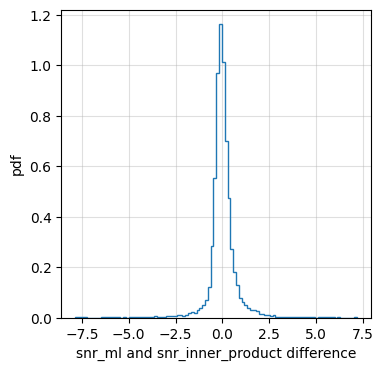

In [17]:
y_pred_ = modelET1.predict(X_).flatten()
y_test_ = Y_.copy()
# y_test = Y_
hist_ = y_pred_-y_test_
idx = (y_test_>6) & (y_test_<10)  # selection wrt snr
# idx = idx & (X_[:,2]>-2)  # selection wrt eta
hist_ = hist_[idx]
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

### Error analysis

In [21]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

try:
    adjustment_dict = load_json('error_adjustment_final.json')
except:
    adjustment_dict = {}
adjustment_dict['ET1'] = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustment_final.json', adjustment_dict)

slope: 0.0005, intercept: -0.0769


In [22]:
# load json
adjustment_dict = load_json('error_adjustment_final.json')
a = adjustment_dict['ET1']['slope']
b = adjustment_dict['ET1']['intercept']

y_pred_ = modelET1.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
[[27013   857]
 [  696 21434]]
Accuracy (after error ajustment): 96.894%


## ET2

In [18]:
# these are pre-generated datas
# join all dictionaries into one
unlensed_params1 = get_param_from_json("ler_data/unlensed_param_ET.json")

# len_ = int(len(unlensed_params1['ET2'])/2)
# print(len_)
# for key, value in unlensed_params1.items():
#     unlensed_params1[key] = value[:len_]

unlensed_params2 = get_param_from_json("ler_data/joint_new_optsnr_ET2.json")

unlensed_params = add_dict_values(unlensed_params1, unlensed_params2)
del unlensed_params1, unlensed_params2

# snr = unlensed_params['ET2']
# idx = snr>0
# for key, value in unlensed_params.items():
#     unlensed_params[key] = value[idx]

# unlensed_params = get_param_from_json("ler_data/unlensed_param_ET.json")

print(f"size before SNR cut: {len(unlensed_params['ET2'])}")
# set SNR cut
idx_constrain = unlensed_params['ET2']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['ET2'])}")

size before SNR cut: 697169
size after SNR cut: 696536


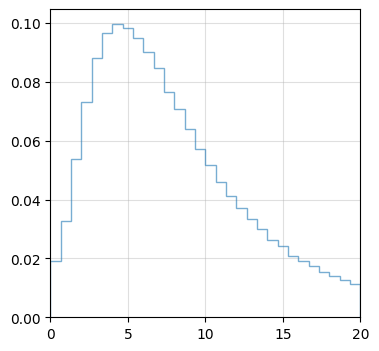

In [19]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['ET2'])
test = test[test<20]
plt.figure(figsize=(4,4))
plt.hist(test, bins=30, alpha=0.6, histtype='step', density=True)
plt.xlim(0,20)
plt.grid(alpha=0.4)
plt.show()

In [20]:
len_ = len(unlensed_params['ET2'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XET2,yET2 = input_output(idx, unlensed_params, det='ET2')
np.shape(XET2)

(696536, 5)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(XET2, yET2, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerET2_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerET2 = pickle.load(open('scalerET2_final.pkl', 'rb'))
# sc = scalerET2
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [22]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 351us/step - accuracy: 5.6604e-05 - loss: 23.8054
Epoch 2/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 347us/step - accuracy: 1.7029e-05 - loss: 3.9941
Epoch 3/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step - accuracy: 2.1186e-05 - loss: 3.7290
Epoch 4/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 365us/step - accuracy: 3.4494e-05 - loss: 3.7794
Epoch 5/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 347us/step - accuracy: 8.4148e-05 - loss: 3.5028
Epoch 6/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 348us/step - accuracy: 1.6213e-04 - loss: 3.5083
Epoch 7/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 342us/step - accuracy: 2.3574e-04 - loss: 3.7162
Epoch 8/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 346us/step - accuracy: 3.0115e-04 - loss: 3.2566
Epoch 9/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 346us/step - accuracy: 4.0042e-04 - loss: 3.4717
Epoch 10/100
19591/19591 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step - accuracy: 5.5153e-04 - loss: 3.1378
Epoch 11/100
19591/19591 ━━━

In [23]:
# Save the model to a file
ann.save('ann_modelET2_final.h5')
modelET2 = ann

In [24]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelET2 = load_model('ann_modelET2_final.h5')

In [25]:
# left: predicted snr, right: actual snr
y_pred = modelET2.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

2177/2177 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
[[10.52247524  9.56997269]
 [ 2.65808439  2.62966915]
 [ 5.36120605  5.33616631]
 [ 4.3813715   4.26774525]
 [ 4.416677    4.14764793]
 [18.76843262 17.88953047]
 [ 4.2925601   4.29928295]
 [ 3.46281862  3.09975251]
 [ 6.3896265   6.2901915 ]
 [13.19214821 13.75831676]
 [ 5.02232265  4.84546348]
 [ 3.6394105   3.53958734]
 [23.15038681 24.78505214]
 [ 2.23121738  2.02530801]
 [ 4.83520555  4.73614035]]


In [26]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.01%


In [27]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37190  1320]
 [  780 30364]]
Accuracy: 96.985%


### Test with astrophysical parameters

In [28]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['ET2'])), unlensed_params, det='ET2')
scalerET2 = pickle.load(open('scalerET2_final.pkl', 'rb'))
X_ = scalerET2.transform(X_)

modelET2 = load_model('ann_modelET2_final.h5')
y_pred_ = modelET2.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
[[26828   979]
 [  534 21659]]
Accuracy: 96.974%


In [29]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

try:
    adjustment_dict = load_json('error_adjustment_final.json')
except:
    adjustment_dict = {}
adjustment_dict['ET2'] = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustment_final.json', adjustment_dict)

slope: 0.0187, intercept: -0.0746


In [30]:
# load json
adjustment_dict = load_json('error_adjustment_final.json')
a = adjustment_dict['ET2']['slope']
b = adjustment_dict['ET2']['intercept']

y_pred_ = modelET2.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
[[26958   849]
 [  655 21538]]
Accuracy (after error ajustment): 96.992%


## ET3

In [31]:
# these are pre-generated datas
# join all dictionaries into one
unlensed_params1 = get_param_from_json("ler_data/unlensed_param_ET.json")

# len_ = int(len(unlensed_params1['ET3'])/2)
# print(len_)
# for key, value in unlensed_params1.items():
#     unlensed_params1[key] = value[:len_]

unlensed_params2 = get_param_from_json("ler_data/joint_new_optsnr_ET3.json")

unlensed_params = add_dict_values(unlensed_params1, unlensed_params2)
del unlensed_params1, unlensed_params2

# snr = unlensed_params['ET3']
# idx = snr>0
# for key, value in unlensed_params.items():
#     unlensed_params[key] = value[idx]

# unlensed_params = get_param_from_json("ler_data/unlensed_param_ET.json")

print(f"size before SNR cut: {len(unlensed_params['ET3'])}")
# set SNR cut
idx_constrain = unlensed_params['ET3']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['ET3'])}")

size before SNR cut: 697283
size after SNR cut: 696635


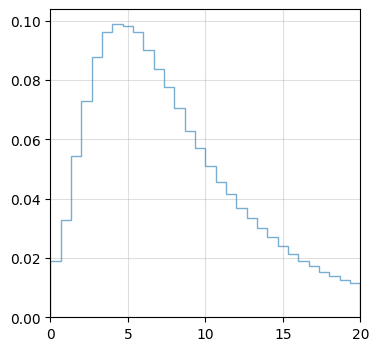

In [32]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['ET3'])
test = test[test<20]
plt.figure(figsize=(4,4))
plt.hist(test, bins=30, alpha=0.6, histtype='step', density=True)
plt.xlim(0,20)
plt.grid(alpha=0.4)
plt.show()

In [33]:
len_ = len(unlensed_params['ET3'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XET3,yET3 = input_output(idx, unlensed_params, det='ET3')
np.shape(XET3)

(696635, 5)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(XET3, yET3, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerET3_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerET3 = pickle.load(open('scalerET3_final.pkl', 'rb'))
# sc = scalerET3
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [35]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 352us/step - accuracy: 4.8169e-05 - loss: 22.6077
Epoch 2/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 349us/step - accuracy: 7.3079e-05 - loss: 3.7918
Epoch 3/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 344us/step - accuracy: 1.0068e-04 - loss: 3.5741
Epoch 4/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 346us/step - accuracy: 1.1910e-04 - loss: 3.3245
Epoch 5/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 349us/step - accuracy: 1.6854e-04 - loss: 3.4585
Epoch 6/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 343us/step - accuracy: 2.6222e-04 - loss: 3.5509
Epoch 7/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 347us/step - accuracy: 2.2820e-04 - loss: 3.2520
Epoch 8/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 347us/step - accuracy: 3.8618e-04 - loss: 3.1127
Epoch 9/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 345us/step - accuracy: 6.5536e-04 - loss: 3.1109
Epoch 10/100
19593/19593 ━━━━━━━━━━━━━━━━━━━━ 7s 344us/step - accuracy: 7.7189e-04 - loss: 3.1389
Epoch 11/100
19593/19593 ━━━

In [36]:
# Save the model to a file
ann.save('ann_modelET3_final.h5')
modelET3 = ann

In [37]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelET3 = load_model('ann_modelET3_final.h5')

In [38]:
# left: predicted snr, right: actual snr
y_pred = modelET3.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

2177/2177 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step
[[ 5.57245541  5.81567874]
 [46.00018311 44.21110949]
 [ 6.35019255  6.44040196]
 [13.57101536 14.21956844]
 [ 5.31488514  6.56740713]
 [ 7.44659281  5.9749794 ]
 [11.38140678 13.34405854]
 [ 5.26468515  5.09018546]
 [ 5.17257738  5.52839025]
 [15.80698776 15.90368436]
 [ 9.94339561 10.55422675]
 [11.15847397 10.64564161]
 [ 4.02502918  4.3257658 ]
 [ 6.32746983  6.52467123]
 [34.57960129 30.74351223]]


In [39]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.99%


In [40]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[37466  1146]
 [  939 30113]]
Accuracy: 97.007%


### Test with astrophysical parameters

In [41]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['ET3'])), unlensed_params, det='ET3')
scalerET3 = pickle.load(open('scalerET3_final.pkl', 'rb'))
X_ = scalerET3.transform(X_)

modelET3 = load_model('ann_modelET3_final.h5')
y_pred_ = modelET3.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
[[27014   810]
 [  738 21438]]
Accuracy: 96.904%


In [42]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<10)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

try:
    adjustment_dict = load_json('error_adjustment_final.json')
except:
    adjustment_dict = {}
adjustment_dict['ET3'] = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustment_final.json', adjustment_dict)

slope: 0.0048, intercept: -0.0472


In [43]:
# load json
adjustment_dict = load_json('error_adjustment_final.json')
a = adjustment_dict['ET3']['slope']
b = adjustment_dict['ET3']['intercept']

y_pred_ = modelET3.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
[[26997   827]
 [  722 21454]]
Accuracy (after error ajustment): 96.902%


## Load all models and test them

In [23]:
from tensorflow.keras.models import load_model
modelET1 = load_model('ann_modelET1_final.h5')
modelET2 = load_model('ann_modelET2_final.h5')
modelET3 = load_model('ann_modelET3_final.h5')

# load the scaler
import pickle
scalerET1 = pickle.load(open('scalerET1_final.pkl', 'rb'))
scalerET2 = pickle.load(open('scalerET2_final.pkl', 'rb'))
scalerET3 = pickle.load(open('scalerET3_final.pkl', 'rb'))

# load the correction slope and intercept
correction = load_json('error_adjustment_final.json')
aET1 = correction['ET1']['slope']
bET1 = correction['ET1']['intercept']
aET2 = correction['ET2']['slope']
bET2 = correction['ET2']['intercept']
aET3 = correction['ET3']['slope']
bET3 = correction['ET3']['intercept']

In [24]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")

In [25]:
XET1_,yET1_,XET2_,yET2_, XET3_,yET3_,yNET_ = input_output(np.arange(len(unlensed_params['ET1'])), unlensed_params, det='NET')

In [26]:
def predict_snr_net_ANN(XET1, XET2, XET3):
    """
        Function to predict the network SNR using the ANN models

        Parameters:
        XET1: input data for ET1, [snr_half_[0], amp0[0], eta, chi_eff, theta_jn]
        XET2: input data for ET2, [snr_half_[1], amp0[1], eta, chi_eff, theta_jn]
        XET3: input data for ET3, [snr_half_[2], amp0[2], eta, chi_eff, theta_jn]

        Returns:
        y: network SNR
    """
    x = scalerET1.transform(XET1)
    yET1 = modelET1.predict(x)
    yET1 = yET1 - (aET1*yET1 + bET1)
    x = scalerET2.transform(XET2)
    yET2 = modelET2.predict(x)
    yET2 = yET2 - (aET2*yET2 + bET2)
    x = scalerET3.transform(XET3)
    yET3 = modelET3.predict(x)
    yET3 = yET3 - (aET3*yET3 + bET3)
    y = np.sqrt(yET1**2 + yET2**2 + yET3**2)

    # mass_1 = np.array(unlensed_params['mass_1'])
    # mass_2 = np.array(unlensed_params['mass_2'])
    # mtot = mass_1 + mass_2
    # y[mtot>gwsnr.mtot_max] = 0.

    # return(y)
    return yET1, yET2, yET3, y

In [27]:
# left: predicted snr, right: actual snr
_,_,_,y_pred_ = predict_snr_net_ANN(XET1_, XET2_, XET3_)
y_pred_ = y_pred_.flatten()
# idx = (y_pred>4) & (y_pred<10)
# y_pred_ = y_pred[idx]
# y_true_ = yNET[idx]
y_true_ = yNET_
print(np.concatenate((y_pred_.reshape(len(y_pred_),1), y_true_.reshape(len(y_true_),1)),1)[10:25])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
[[28.53900528 29.83070384]
 [46.29739761 54.33960261]
 [17.75957108 15.33198284]
 [22.81264496 22.41579184]
 [14.09397507 12.4347551 ]
 [ 6.52673721  6.33845441]
 [10.80855846 10.29623933]
 [ 0.16650869  0.        ]
 [ 8.32227707  7.83343622]
 [ 8.61046124  8.69505497]
 [ 5.06292486  4.71481899]
 [25.84856224 23.25769735]
 [ 7.74353743  8.15459608]
 [ 5.98157406  5.73405412]
 [12.89855385 12.58034079]]


In [28]:
_,_,_,y_pred_ = predict_snr_net_ANN(XET1_, XET2_, XET3_)
y_pred_ = y_pred_.flatten()
# idx = (y_pred>4) & (y_pred<10)
# y_pred_ = y_pred[idx]
# y_true_ = yNET[idx]
y_true_ = yNET_
cm = confusion_matrix((y_true_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_true_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
[[11404   958]
 [  367 37271]]
Accuracy: 97.350%


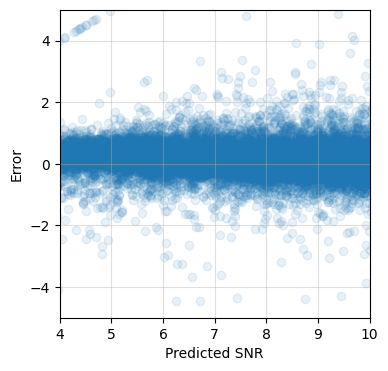

In [29]:
# idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_, y_pred_-y_true_, alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-5,5)
plt.grid(alpha=0.4)
plt.show()